In [1]:
import warnings
warnings.filterwarnings("ignore")
from dataset import AudioDataset, AugmentedDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch
from model import LSTMnet_GateAtten
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
def return_all_items(dataset):
    all_items = []
    print(len(dataset))
    for i in range(len(dataset)):
        all_items.append(dataset[i])
    return all_items

In [4]:
train_annotations = '/Users/zuzia/Downloads/MELD.Raw/train/train_sent_emo.csv'
val_annotations = '/Users/zuzia/Downloads/MELD.Raw/dev_sent_emo.csv'

train_audio = '/Users/zuzia/Downloads/MELD.Raw/train/train_splits/wav'
val_audio = '/Users/zuzia/Downloads/MELD.Raw/dev_splits_complete/wav'

In [5]:
train1 = AudioDataset(train_annotations, train_audio, 0)
train2 = AudioDataset(train_annotations, train_audio, 1)

list1 = return_all_items(train1)
list2 = return_all_items(train2)
list1.extend(list2)

5279
5279


In [3]:
train = AugmentedDataset(list1)
val = AudioDataset(val_annotations, val_audio, 0)

train_dataloader = DataLoader(train, batch_size=32, shuffle = True, drop_last=False)
val_dataloader = DataLoader(val, batch_size=32, shuffle=False, drop_last=False)
train_features, train_labels = next(iter(train_dataloader))

In [16]:
# Sanity check: Size should be [batch_size, num_features, feature_vector_len], [batch_size]
# Where batch size is 32, num_features (num mfccs, num mel) is 104
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# Length should be 9988*2
print(f"Length of the train data: {len(train)}")

Feature batch shape: torch.Size([32, 104])
Labels batch shape: torch.Size([32])
Length of the train data: 10558


In [8]:
for batch in train_dataloader:
    x, y = batch
    print(x.shape, y.shape)
    break


torch.Size([32, 104]) torch.Size([32])


In [9]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [10]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits = model(X)
        predictions = torch.argmax(output_logits,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100, f1
    return train_step

In [11]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits = model(X)
            predictions = torch.argmax(output_logits,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, f1, predictions
    return validate

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMnet_GateAtten(input_dim = 104, hidden_dim=128, output_dim=6, num_layers=1).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.1, weight_decay=1e-3)


Number of trainable params:  137479


In [13]:
train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)

val_accs = []
losses=[]
val_losses = []
f1s = []
val_f1s= []
epochs = 150
best_val_f1 = 0

for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    epoch_f1 = 0
    for idx, (features, labels) in enumerate(train_dataloader):
        X, Y = features, labels
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc, f1= train_step(X_tensor,Y_tensor)
        epoch_acc += acc*len(features)/len(train)
        epoch_loss += loss*len(features)/len(train)
        epoch_f1 += f1*len(features)/len(train)
    for batch in val_dataloader:
        X_val, Y_val = batch
        break
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, val_f1, _ = validate(X_val_tensor,Y_val_tensor)
    val_accs.append(val_acc.cpu())
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    f1s.append(epoch_f1)
    val_f1s.append(val_f1)
    
    if val_f1 >= best_val_f1:
        torch.save(model, f'best-model-parameters-{epoch}-audio-sent-negposneut.pt')
        best_epoch = epoch
        best_val_f1 = val_f1
        
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, f1:{f1:.2f}, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%, val_f1:{val_f1:.2f}")


Epoch 0 --> loss:1.6058, acc:32.32%, f1:0.12, val_loss:1.4452, val_acc:15.62%, val_f1:0.04

Epoch 1 --> loss:1.5914, acc:32.81%, f1:0.28, val_loss:1.4826, val_acc:21.88%, val_f1:0.15

Epoch 2 --> loss:1.5898, acc:32.65%, f1:0.16, val_loss:1.4557, val_acc:15.62%, val_f1:0.05

Epoch 3 --> loss:1.5881, acc:32.93%, f1:0.15, val_loss:1.5120, val_acc:15.62%, val_f1:0.04

Epoch 4 --> loss:1.5893, acc:33.44%, f1:0.13, val_loss:1.5134, val_acc:15.62%, val_f1:0.04

Epoch 5 --> loss:1.5864, acc:33.01%, f1:0.37, val_loss:1.4071, val_acc:15.62%, val_f1:0.04

Epoch 6 --> loss:1.5847, acc:33.07%, f1:0.21, val_loss:1.4129, val_acc:31.25%, val_f1:0.29

Epoch 7 --> loss:1.5863, acc:33.03%, f1:0.16, val_loss:1.4932, val_acc:18.75%, val_f1:0.10

Epoch 8 --> loss:1.5858, acc:33.14%, f1:0.38, val_loss:1.5609, val_acc:18.75%, val_f1:0.10

Epoch 9 --> loss:1.5867, acc:33.25%, f1:0.32, val_loss:1.4815, val_acc:18.75%, val_f1:0.10

Epoch 10 --> loss:1.5817, acc:33.72%, f1:0.29, val_loss:1.4752, val_acc:15.62%,

KeyboardInterrupt: 

In [17]:
def predict(model, val_dataloader):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    f1s = []
    for batch in val_dataloader:
        X, Y = batch
        with torch.no_grad():        
            outputs = model(X)
            predictions = torch.argmax(outputs,dim=1)
            f1 = f1_score(Y.cpu(), predictions.cpu(), average=None)
            f1s.append(f1)
    return f1s

In [18]:
model = torch.load('best-model-parameters-6-audio-sent-negposneut.pt')
f1s = predict(model, val_dataloader)

In [25]:
els = []
for el in f1s:
    if el.shape[0] == 6:
        els.append(el)
np.mean(els,axis=1)

array([0.05405405, 0.06095238, 0.05376344, 0.09259259, 0.14215686,
       0.02150538, 0.18955453])

layers:  3
model hidden dim:  128
batch size:  64


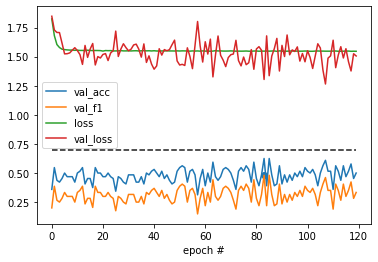

In [13]:
import matplotlib.pyplot as plt
x = range(epochs)

fig, ax = plt.subplots()
ax.set_xlabel('epoch #')
ax.set_ylabel('')
ax.plot(x,np.divide(val_accs,100), label='val_acc')
ax.plot(x,np.divide(val_f1s,100), label='val_f1')
ax.plot(x, losses, label='loss')
ax.plot(x, val_losses, label='val_loss')
ax.scatter(best_epoch, best_val_f1/100)
ax.plot(x, 0.7*np.ones(len(x)), '--', color=(0.1,0.1,0.1))
ax.legend()
print("layers: ", model.num_layers)
print("model hidden dim: ", model.hidden_dim)
print("batch size: ", train_dataloader.batch_size)

